In [1]:
import plotly.plotly as py
import plotly.graph_objs as go
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import datetime
import numpy as np
import os, sys
import math
from matplotlib import cm
from matplotlib.patches import Circle,Wedge,Rectangle
%matplotlib inline

In [2]:
data=pd.read_excel(r"N:\Planning - New File Structure\Performance\RidershipAutomation.xlsx")
df=pd.DataFrame(data)

In [3]:
routes=pd.read_csv(r"N:\Planning - New File Structure\GIS\Data\GTFS\VRT5_10_18\routes.txt")
df=df.merge(routes,how='left',on='route_id')

In [4]:
dropcols=['agency_id','route_short_name','route_long_name','route_desc','route_type','route_url','route_text_color']
df.set_index(['Stat','Service','Route','Area','route_color','route_id'],inplace=True)
df.drop(columns=dropcols,inplace=True)

In [5]:
df.columns=pd.to_datetime(df.columns)

In [6]:
UPT_FR_18=df.loc[['UPT','FR'],datetime.date(year=2017,month=10,day=1):datetime.date(year=2018,month=9,day=1)]
UPT_FR_17=df.loc[['UPT','FR'],datetime.date(year=2016,month=10,day=1):datetime.date(year=2017,month=9,day=1)]

In [7]:
UPT_FR_17_Total=UPT_FR_17.sum(axis=0).sum()
UPT_FR_18_Total=UPT_FR_18.sum(axis=0).sum()

In [8]:
YearOverYearRidership=(UPT_FR_18_Total-UPT_FR_17_Total).round(-2)
YearOverYearRidershipPct=int(((UPT_FR_18_Total/UPT_FR_17_Total)-1)*100)
YearOverYearRidershipPct

10

In [9]:
ring_data=pd.DataFrame([UPT_FR_18_Total,UPT_FR_17_Total]).T
ring_data.columns=['2018','2017']

In [10]:
by_route18=df.loc[:,datetime.date(year=2017,month=10,day=1):datetime.date(year=2018,month=9,day=1)].groupby(['Route','route_color']).sum()
by_route17=df.loc[:,datetime.date(year=2016,month=10,day=1):datetime.date(year=2017,month=9,day=1)].groupby(['Route','route_color']).sum()

by_route18=by_route18.sum(axis=1)
by_route17=by_route17.sum(axis=1)

ring_data_routes=pd.DataFrame([by_route18,by_route17]).T
ring_data_routes.columns=['2018','2017']

In [11]:
ring_data_routes['PercentChange']=ring_data_routes['2018']/ring_data_routes['2017']
ring_data_routes['Change']=ring_data_routes['2018']-ring_data_routes['2017']

In [12]:
ring_data_routes['Arrow']=pd.qcut(ring_data_routes['PercentChange'],6,labels=[1,2,3,4,5,6])
ring_data_routes['Size']=pd.qcut(ring_data_routes['Change'],6,labels=[1,2,3,4,5,6])
ring_data_routes['Arrow']=ring_data_routes.Arrow.astype(float)
ring_data_routes['Size']=ring_data_routes.Size.astype(int)

C:\Users\bparker\AppData\Local\conda\conda\envs\mappingPy3\lib\site-packages\pandas\core\algorithms.py:1036: RuntimeWarning:

invalid value encountered in double_scalars



In [13]:
positive=ring_data_routes[ring_data_routes.Change>0]
positive['Arrow']=pd.qcut(positive['PercentChange'],3,labels=[0,45,90])
positive['Size']=pd.qcut(positive['Change'],3,[.25,.5,.75])
negative=ring_data_routes[ring_data_routes.Change<0]
negative['Arrow']=pd.qcut(negative['PercentChange'],3,labels=[-90,-45,0])
negative['Size']=pd.qcut(negative['Change'],3,labels=[.25,.5,.75])
negative
ring_data_routes=pd.concat([positive,negative])
ring_data_routes.head()

C:\Users\bparker\AppData\Local\conda\conda\envs\mappingPy3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\bparker\AppData\Local\conda\conda\envs\mappingPy3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\bparker\AppData\Local\conda\conda\envs\mappingPy3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

,,2018,2017,PercentChange,Change,Arrow,Size
Route,route_color,,,,,,
1 Parkcenter,#ffcd00,73101.0,73017.0,1.001150,84.0,0,0.25
10X,#fbb161,2256.0,1835.0,1.229428,421.0,45,0.25
12 Maple Grove,#b6bd00,40426.0,30873.0,1.309429,9553.0,45,0.50
2 Broadway,#685bc7,63058.0,60109.0,1.049061,2949.0,0,0.25
28 Overland Victory,#51284f,38861.0,38220.0,1.016771,641.0,0,0.25


In [14]:
arrow=ring_data_routes.iloc[:,4]
size=ring_data_routes.iloc[:,5]
needs=pd.DataFrame([arrow,size]).T

In [15]:
needs.Arrow=needs.Arrow.map(float)
needs.Size=needs.Size.map(float)

In [16]:
ring_data_routes.reset_index(inplace=True)

In [26]:
def arrowdrawer(df,figsize,fname=False):
    fig=plt.figure(figsize=figsize)
    for i, (name,row) in enumerate(df.iterrows()):
        ax=plt.subplot(10,4,i+1)
        ax.set_title(row['Route'])
        x0,y0=1,1
        radius=row['Size']
        angle=row['Arrow']
        angle_rad = angle * math.pi / 180  # degrees to radians
        head_length=.025*(10*row['Size'])
        ax.arrow(x0,y0,
                (radius)*math.cos(angle_rad),
                (radius)*math.sin(angle_rad),
                head_width=head_length,head_length=head_length,color=row['route_color'],width=head_length/2)
        ax.add_patch(Circle((x0,y0), radius=head_length/4,color=row['route_color']))
        ax.table(cellText=round(row['PercentChange']))
        plt.axis([0,2,0,2])
        plt.axis('off')
    


TypeError: object of type 'int' has no len()

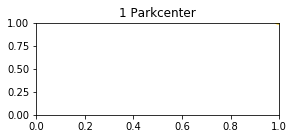

In [27]:
arrowdrawer(ring_data_routes,figsize=(20,20))